In [2]:
from pl_modules import *
from pl_datasets import *
import torch
import numpy as np
import random

In [3]:
 dm = NPDataModule(dataset_type='gpdata',
                      num_workers=4,
                      batch_size=16,
                      kernel='rbf',
                      num_samples=100,
                      num_points=100,
                      lengthscale_range=(0.25, 0.5),
                      sigma_range=(1,1),
                      )

In [4]:
model = PLNeuralProcess.load_from_checkpoint('/homes/gp491/AML/AML_neural_processes/1200_gp_rbf.ckpt')

In [5]:
rng = np.random.default_rng()


In [23]:
x, y, l, s, p = dm.val_dataloader().dataset.generate_gp_sample(rng)
model_x, model_y = torch.tensor(x).float().to(model.device).unsqueeze(0), torch.tensor(y).float().to(model.device).unsqueeze(0).unsqueeze(2)
kernel_type = dm.val_dataloader().dataset.kernel

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel

In [7]:
def random_search(x, y):
    min_id = np.argmin(y)
    rand_id = -1
    n = 0
    while not rand_id == min_id:
        n += 1
        rand_id = random.randint(0, x.shape[0] -1)
    return n

In [8]:
def random_search_no_rep(x, y):
    min_id = np.argmin(y)
    idxs = list(range(x.shape[0]))
    random.shuffle(idxs)
    return idxs.index(min_id) + 1   

In [9]:
def gp_thompson(x, y, kernel_type, s, l, p):
    
    if kernel_type == 'rbf':
        kernel = ConstantKernel(s**2, constant_value_bounds = "fixed") * RBF(length_scale=l, length_scale_bounds="fixed")
    elif kernel_type == 'matern':
        kernel = ConstantKernel(s**2, constant_value_bounds = "fixed") * Matern(length_scale=l, length_scale_bounds="fixed")
    else:
        kernel = ConstantKernel(s**2, constant_value_bounds = "fixed") * ExpSineSquared(length_scale=l, length_scale_bounds="fixed", periodicity=p,                                         periodicity_bounds="fixed")
    
    min_id = np.argmin(y)
    x_at_min = x[min_id]

    # print(f'min x {x_at_min}, min y {y[min_id]}' )
    
    sample_min = random.randint(0, x.shape[0]-1)
    next_x = x[sample_min]
    xs = np.array(next_x).reshape((-1, 1))
    ys = np.array(y[sample_min]).reshape((1, -1))
    gpr = GaussianProcessRegressor(kernel)

    while not (sample_min == min_id):
        # print(next_x)
        xs = xs.reshape((-1, 1))
        gpr.fit(xs, ys)
        sample = gpr.sample_y(x.reshape((-1, 1)))
        sample_min = np.argmin(sample)
        if xs.shape[0] > 150:
            # print(next_x, sample_min, min_id, sample[sample_min])
            # plt.plot(x, sample)
            # if xs.shape[0] > 53:
            #     plt.scatter(xs, ys)
            return  -1
        next_x = x[sample_min]

        xs = np.append(xs, next_x)
        ys = np.append(ys, y[sample_min])

    return xs.shape[0]


In [25]:
gp_thompson(x.flatten(), y, 'rbf', s, l, p)

8

In [10]:
def np_thompson(np_x, np_y, x, y, model):
    
    min_id = np.argmin(y)
    x_at_min = x[min_id]

    # print(f'min x {x_at_min}, min y {y[min_id]}' )
    
    rand_id = random.randint(0, x.shape[0]-1)
    next_x = x[rand_id]
    point_ids = [rand_id]
    while not (next_x == x_at_min):
        # print(next_x)
        x_context = np_x[:, point_ids, :]
        y_context = np_y[:, point_ids, :]

        p_y_pred, _, _ = model.model(x_context.to(model.device),
                                y_context.to(model.device),
                                np_x.to(model.device), None)

        sample = p_y_pred.loc.detach().cpu().numpy().flatten()
        sample_min = np.argmin(sample)
        
        next_x = x[sample_min]

        point_ids.append(sample_min)

        if len(point_ids) > 300:
            return  -1

    return len(point_ids)

In [27]:
model.eval()
np_vals = []
gp_vals = []
rand_vals = []
for i in range(100):

    print('iteration ', i) 

    x, y, l, s, p = dm.val_dataloader().dataset.generate_gp_sample(rng)
    np_x, np_y = torch.tensor(x).float().to(model.device).unsqueeze(0), torch.tensor(y).float().to(model.device).unsqueeze(0).unsqueeze(2)
    kernel_type = dm.val_dataloader().dataset.kernel
    
    # np_val = -1
    # restarts = -1
    # while np_val < 0:
    #     restarts += 1
    #     np_val = np_thompson(np_x, np_y, x.flatten(), y, model)
    # print('NP: ', np_val, ' restarts ', restarts)

    gp_val = -1
    restarts = -1
    while gp_val < 0: 
        restarts += 1
        gp_val = gp_thompson(x.flatten(), y, 'rbf', s, l, p)
    print('GP: ', gp_val, ' restarts ', restarts)

    rand_val = random_search(x.flatten(), y)
    print('Rand: ', rand_val)

    np_vals.append(np_val)
    gp_vals.append(gp_val)
    rand_vals.append(rand_val)

iteration  0
GP:  9  restarts  0
Rand:  43
iteration  1
GP:  6  restarts  0
Rand:  9
iteration  2
GP:  31  restarts  0
Rand:  102
iteration  3


KeyboardInterrupt: 

In [13]:
rand_np = np.array(rand_vals)
gp_np = np.array(gp_vals)
np_np = np.array(np_vals)

In [14]:
print('Random mean steps ', np.mean(rand_np))
print('GP mean steps ', np.mean(gp_np))
print('NP mean steps ', np.mean(np_np) )

Random mean steps  321.34090909090907
GP mean steps  11.886363636363637
NP mean steps  -1.0


In [15]:
print('Random mean steps (normalised) ', np.mean(rand_np)/np.mean(rand_np))
print('GP mean steps (normalised) ', np.mean(gp_np)/np.mean(rand_np))
print('NP mean steps (normalised) ', np.mean(np_np)/np.mean(rand_np) )

Random mean steps (normalised)  1.0
GP mean steps (normalised)  0.03698988613056087
NP mean steps (normalised)  -0.0031119598274276824


In [243]:
np.savez('thompson_3k.npz', rand_vals = rand_np, gp_vals = gp_np, np_vals = np_np)

In [11]:
def np_thompson_return_all(np_x, np_y, x, y, model):
    
    min_id = np.argmin(y)
    x_at_min = x[min_id]

    # print(f'min x {x_at_min}, min y {y[min_id]}' )
    samples = []
    
    rand_id = random.randint(0, x.shape[0]-1)
    next_x = x[rand_id]
    point_ids = [rand_id]
    while not (next_x == x_at_min):
        # print(next_x)
        x_context = np_x[:, point_ids, :]
        y_context = np_y[:, point_ids, :]

        p_y_pred, _, _ = model.model(x_context.to(model.device),
                                y_context.to(model.device),
                                np_x.to(model.device), None)

        sample = p_y_pred.loc.detach().cpu().numpy().flatten()
        sample_min = np.argmin(sample)

        samples.append(sample)
        
        next_x = x[sample_min]

        point_ids.append(sample_min)

        if len(point_ids) > 300:
            return -1, [], []

    return len(point_ids), samples, point_ids

In [34]:
def plot_thompson_process(samples, point_ids, x, y):
    fig, axs = plt.subplots(2, len(samples) // 2 + len(samples) % 2, figsize = (4*(len(samples) //2), 6))
    axs = axs.flatten()
    for i in range(len(samples)):
        axs[i].plot(x, y, color='#264653', linestyle='dashed')
        axs[i].plot(x, samples[i], '#2a9d8f')
        if i > 0:
            axs[i].scatter(x[point_ids[:i]], y[point_ids[:i]], c='#264653')
            axs[i].scatter([x[point_ids[i]]], [y[point_ids[i]]], c='#e76f51')
        else:
            axs[i].scatter([x[point_ids[i]]], [y[point_ids[i]]], c='#264653')
        
        axs[i].set_ylim((-2, 2))
        axs[i].set_yticks([2, 1, 0, -1, -2])
        axs[i].set_yticklabels([2, 1, 0, -1, -2])

        axs[i].set_title(f'Step {i}', fontsize=20, color='#264653')
        
        axs[i].scatter([x[point_ids[i+1]]], [samples[i][point_ids[i+1]]- 0.05] , c='#e76f51', marker='^')
    fig.tight_layout()

    plt.savefig('thompthomp.svg')

In [13]:
model.eval()

PLNeuralProcess(
  (model): SimpleNP(
    (encoder): LinearEncoder(
      (to_r): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU(inplace=True)
        (6): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (decoder): LinearDecoder(
      (to_hidden): Sequential(
        (0): Linear(in_features=129, out_features=128, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU(inplace=True)
      )
      (to_mu): Linear(in_features=128, out_features=1, bias=True)
      (to_sigma): Linear(in_features=128, out_features=1, bias=True)
    )
    (combiner): MeanCombiner()

In [28]:
l = 0
while not l == 5:
    x, y, l, s, p = dm.val_dataloader().dataset.generate_gp_sample(rng)
    model_x, model_y = torch.tensor(x).float().to(model.device).unsqueeze(0), torch.tensor(y).float().to(model.device).unsqueeze(0).unsqueeze(2)
    n, samples, points = np_thompson_return_all(model_x, model_y, x.flatten(), y, model)
    l = len(points)

In [29]:
len(points)


5

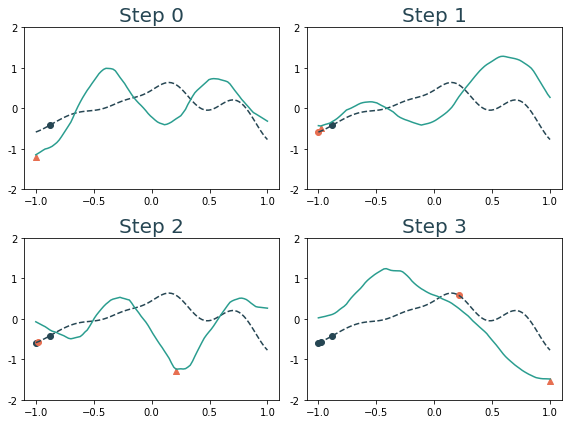

In [40]:
plot_thompson_process(samples, points, x.flatten(), y)

In [18]:
import matplotlib.pyplot as plt

In [39]:
plt.savefig('thompthomp.svg')

<Figure size 432x288 with 0 Axes>

In [118]:
points

[80, 78, 27, 71, 99]

In [119]:
samples

[array([-0.08213306, -0.10105955, -0.13851695, -0.16786587, -0.19679031,
        -0.22601967, -0.251073  , -0.26706135, -0.28590763, -0.30133626,
        -0.32258117, -0.35541582, -0.39148313, -0.42329246, -0.45600206,
        -0.48850185, -0.5133956 , -0.542361  , -0.56538296, -0.5693778 ,
        -0.5740866 , -0.57876503, -0.5820985 , -0.5823381 , -0.5821941 ,
        -0.5832784 , -0.5849108 , -0.5764875 , -0.5626571 , -0.54882526,
        -0.53734964, -0.5359639 , -0.53542185, -0.53488004, -0.5382746 ,
        -0.5421761 , -0.54603887, -0.55621064, -0.56305665, -0.56615806,
        -0.57162714, -0.57889724, -0.5795319 , -0.5861299 , -0.59780276,
        -0.62534165, -0.65150476, -0.68526983, -0.72797513, -0.77058816,
        -0.8037145 , -0.8361622 , -0.8704844 , -0.9019619 , -0.9306609 ,
        -0.9594538 , -0.99024665, -1.0227962 , -1.0500853 , -1.0785486 ,
        -1.1086855 , -1.14306   , -1.1775391 , -1.2115145 , -1.24549   ,
        -1.2794656 , -1.3132505 , -1.343328  , -1.3